# Section 3 - Identifying features that may drive outcomes

## Example 3.3

**Application 3.3**: Given that a protein has an entanglement, what structural and topological features of that entanglement influence whether or not it is linked with disease?

* Not all entanglements are the same - for example, entanglements can differ in the number of contacts that close the loop (**Figure 3.3.1**)
![](../images/Nzip-figure.png)

**Figure 3.3.1** *Different entanglements have different features. For example, they may differ in the number of native contacts (i.e., non-covalent interactions between amino acids) that close the loop segment. The entanglement shown here has N<sub>zip</sub> = 4.*

* In this example we will explore the question of which entanglement features contribute the most to whether or not an entanglement will be linked with disease


### Step 0 - Load libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Step 1 - Load the data & explore

In [2]:
# data8 is a pandas DataFrame object
data_path = "/home/jovyan/data-store/data/iplant/home/shared/NCEMS/BPS-training-2025/"
data8     = pd.read_csv(data_path+"entanglement-features-disease-assoc.csv")

# drop a few columns that we will not use for this analysis
data8     = data8.drop(["Entanglement", "gene", "min_N_prot_depth_left", "min_C_prot_depth_right", "CCBond"], axis = 1)

print ("The first ten rows of the DataFrame:\n")
display(data8.head(10))

print ("\nSome summary information:\n")
display(data8.info())

The first ten rows of the DataFrame:



,Gn,Gc,N_term_thread,C_term_thread,loopsize,num_zipper_nc,num_loop_contacting_res,num_cross_nearest_neighbors,Length,Travatos_G,Gsum,Gmax,disease-linked
0,0.65841,0.04822,1,0,106,1,150,30,NaN,0.763,0.70663,0.65841,Yes
1,0.65792,0.04800,1,0,106,1,152,29,254.0,0.749,0.70592,0.65792,Yes
2,0.07126,0.85529,0,1,33,1,76,31,1052.0,1.388,0.92655,0.85529,No
3,0.72638,0.04703,1,0,31,1,81,29,1052.0,1.388,0.77341,0.72638,No
4,0.28519,0.95181,0,1,386,6,517,41,1052.0,1.388,1.23700,0.95181,No
5,0.61006,0.11921,1,0,310,14,397,42,1052.0,1.388,0.72927,0.61006,No
6,1.01949,0.69981,1,1,451,23,678,66,1052.0,1.388,1.71930,1.01949,No
7,0.75673,0.18017,1,0,385,5,477,34,1052.0,1.388,0.93690,0.75673,No
8,0.91112,0.08235,1,0,82,36,146,37,1052.0,1.388,0.99347,0.91112,No
9,0.75917,0.08707,1,0,86,14,155,36,1052.0,1.388,0.84624,0.75917,No



Some summary information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14197 entries, 0 to 14196
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gn                           14197 non-null  float64
 1   Gc                           14197 non-null  float64
 2   N_term_thread                14197 non-null  int64  
 3   C_term_thread                14197 non-null  int64  
 4   loopsize                     14197 non-null  int64  
 5   num_zipper_nc                14197 non-null  int64  
 6   num_loop_contacting_res      14197 non-null  int64  
 7   num_cross_nearest_neighbors  14197 non-null  int64  
 8   Length                       14196 non-null  float64
 9   Travatos_G                   13445 non-null  float64
 10  Gsum                         14197 non-null  float64
 11  Gmax                         14197 non-null  float64
 12  disease-linked               14197 non-null  o

None

* What we are trying to predict is `disease-linked`, which is `Yes` if the protein is linked with disease and `No` if it is not
* The features we will use to build the model are all of the columns with the exception of `disease-linked`, which is our outcome
* We need to do a few additional processing steps:
    * 752 rows do not have a value of `Travatos_G`; we must remove these rows with `NaN` values to avoid errors down the line
    * 1 row is also missing `Length`; we will remove this row as well
    * We need to check to make sure our features have been scaled correctly and scale them if they have not

In [3]:
# remove rows containing NaN values
data8 = data8.dropna(subset = ["Travatos_G", "Length"])

print ("Some summary information:\n")
display(data8.info())

print ("\nHere is additional summary info on the DataFrame:\n")
data8.describe()

Some summary information:

<class 'pandas.core.frame.DataFrame'>
Index: 13444 entries, 1 to 14196
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gn                           13444 non-null  float64
 1   Gc                           13444 non-null  float64
 2   N_term_thread                13444 non-null  int64  
 3   C_term_thread                13444 non-null  int64  
 4   loopsize                     13444 non-null  int64  
 5   num_zipper_nc                13444 non-null  int64  
 6   num_loop_contacting_res      13444 non-null  int64  
 7   num_cross_nearest_neighbors  13444 non-null  int64  
 8   Length                       13444 non-null  float64
 9   Travatos_G                   13444 non-null  float64
 10  Gsum                         13444 non-null  float64
 11  Gmax                         13444 non-null  float64
 12  disease-linked               13444 non-null  object 

None


Here is additional summary info on the DataFrame:



,Gn,Gc,N_term_thread,C_term_thread,loopsize,num_zipper_nc,num_loop_contacting_res,num_cross_nearest_neighbors,Length,Travatos_G,Gsum,Gmax
count,13444.000000,13444.000000,13444.000000,13444.000000,13444.000000,13444.000000,13444.000000,13444.000000,13444.000000,13444.000000,13444.000000,13444.000000
mean,0.537202,0.464290,0.753794,0.627269,118.735942,15.453362,185.859342,43.283844,518.990925,1.493385,1.001492,0.828032
std,0.388302,0.413171,0.835724,0.864176,107.432564,23.091346,123.966033,20.695554,223.723213,0.421997,0.372187,0.242242
min,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,29.000000,17.000000,58.000000,0.648000,0.600540,0.600000
25%,0.115702,0.076620,0.000000,0.000000,41.000000,2.000000,95.000000,32.000000,352.000000,1.200000,0.771740,0.678148
50%,0.653080,0.364190,1.000000,0.000000,76.000000,7.000000,144.000000,36.000000,490.000000,1.380000,0.882915,0.767510
75%,0.789382,0.772515,1.000000,1.000000,167.000000,20.000000,253.000000,42.000000,645.000000,1.738000,1.069583,0.887605
max,3.246630,2.730150,9.000000,8.000000,969.000000,342.000000,1033.000000,204.000000,1133.000000,3.636000,3.972640,3.246630


* We can see from the output of the previous cell that the features have *not* been scaled - we can do this with the code below

In [4]:
# perform feature scaling
features                 = data8.drop(columns = ["disease-linked"])
outcome                  = data8["disease-linked"]
scaler                   = StandardScaler()
scaled_features          = scaler.fit_transform(features)
scaled                   = pd.DataFrame(scaled_features, columns = features.columns)
scaled["disease-linked"] = outcome.reset_index(drop=True)
data8                    = scaled

# print description of the updated data8 DataFrame
data8.describe()

,Gn,Gc,N_term_thread,C_term_thread,loopsize,num_zipper_nc,num_loop_contacting_res,num_cross_nearest_neighbors,Length,Travatos_G,Gsum,Gmax
count,1.344400e+04,1.344400e+04,1.344400e+04,1.344400e+04,1.344400e+04,1.344400e+04,1.344400e+04,1.344400e+04,1.344400e+04,1.344400e+04,1.344400e+04,1.344400e+04
mean,2.602963e-16,-8.244917e-17,-5.390907e-17,1.072896e-16,6.765060e-17,-2.748306e-17,-5.496611e-17,1.120463e-16,1.860392e-16,4.333867e-16,3.805346e-17,1.564420e-16
std,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00,1.000037e+00
min,-1.383515e+00,-1.123764e+00,-9.019982e-01,-7.258842e-01,-1.030787e+00,-6.259444e-01,-1.265388e+00,-1.270071e+00,-2.060618e+00,-2.003371e+00,-1.077326e+00,-9.413748e-01
25%,-1.085533e+00,-9.383138e-01,-9.019982e-01,-7.258842e-01,-7.236059e-01,-5.826366e-01,-7.329647e-01,-5.452506e-01,-7.464453e-01,-6.952554e-01,-6.173249e-01,-6.187617e-01
50%,2.984342e-01,-2.422814e-01,2.946136e-01,-7.258842e-01,-3.978080e-01,-3.660972e-01,-3.376804e-01,-3.519652e-01,-1.295887e-01,-2.686961e-01,-3.186064e-01,-2.498502e-01
75%,6.494691e-01,7.460256e-01,2.946136e-01,4.313300e-01,4.492665e-01,1.969052e-01,5.416254e-01,-6.203709e-02,5.632574e-01,5.796830e-01,1.829547e-01,2.459330e-01
max,6.977889e+00,5.484272e+00,9.867508e+00,8.531830e+00,7.914692e+00,1.414204e+01,6.833906e+00,7.766022e+00,2.744605e+00,5.077514e+00,7.983245e+00,9.984598e+00


* Now that we have scaled the features, we need to check to see if the outcome classes are balanced

In [5]:
# calculate counts per outcome class
class_counts = data8["disease-linked"].value_counts()
print (class_counts)

disease-linked
Yes    7321
No     6123
Name: count, dtype: int64


* 54% of the proteins have outcome `Yes` and 46% have outcome `No`
* The classes are roughly balanced, but it will be important to keep this in mind during training and when assessing our results

### Step 2 - Prepare data for model building

* As in **Examples 3.1** & **3.2**, we will use k-fold cross-validation with a grid search over *λ*

In [6]:
# set random seed to achieve reproducible results
random_seed = 1

# number of folds for cross-validation
Nfolds      = 5

# we need to recode data in y to be binary integers rather than "Yes" and "No"
recode_map  = {"Yes": 1, "No": 0}
data8['disease-linked'] = data8['disease-linked'].map(recode_map)

# define feature and outcome data sets
X = data8.drop(["disease-linked"], axis = 1)
y = data8["disease-linked"]

# reserve 20% of data for final testing after hyperparameter tuning
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2, random_state = random_seed, stratify=y)

# set up k-fold cross-validation with outcome stratification
kf          = StratifiedKFold(n_splits = Nfolds, shuffle = True, random_state = 1)

# define a range of lambda values to be used in our grid search
lambda_vals = np.logspace(-1, 4, 6)

### Step 3 - Optimize *λ*

In [7]:
# record the start time
startTime    = datetime.now()

# maximum number of iterations to be run
max_iter     = 20000

# setup dictionary to store results for each value of lambda
results_dict = {}

# loop over lambda values
for lambda_val in lambda_vals:

    # setup logistic regression model
    model                    = LogisticRegression(penalty = "l1", solver = "saga", 
                                                  max_iter = max_iter, C = 1/lambda_val)

    # run cross-validation for current lambda_val
    cv_results               = cross_validate(model, X_train, y_train, cv = kf, return_estimator = True, 
                                              scoring = ['balanced_accuracy', 'roc_auc'], n_jobs = -1)

    # store results for later
    results_dict[lambda_val] = cv_results

    # calculation elapsed time and print it to the screen
    elapsed_sec              = (datetime.now() - startTime).total_seconds()
    print(f"{lambda_val:10.4f} {elapsed_sec:10.2f} s")

    0.1000       0.91 s
    1.0000       1.42 s
   10.0000       1.90 s
  100.0000       2.35 s
 1000.0000       2.39 s
10000.0000       2.43 s


* As in **3.1** and **3.2**, we will now assess performance and number of features as a function of *λ*

Lambda      Balanced Acc (mean ± std)  AUROC (mean ± std)            Non-zero Coeffs (mean ± std)
    0.1000	0.583 ± 0.006		0.620 ± 0.008		      11.2 ±        0.4
    1.0000	0.584 ± 0.006		0.620 ± 0.008		      10.8 ±        0.4
   10.0000	0.585 ± 0.005		0.620 ± 0.008		       8.8 ±        1.1
  100.0000	0.576 ± 0.005		0.619 ± 0.008		       3.0 ±        0.7
 1000.0000	0.500 ± 0.000		0.500 ± 0.000		       0.0 ±        0.0
10000.0000	0.500 ± 0.000		0.500 ± 0.000		       0.0 ±        0.0


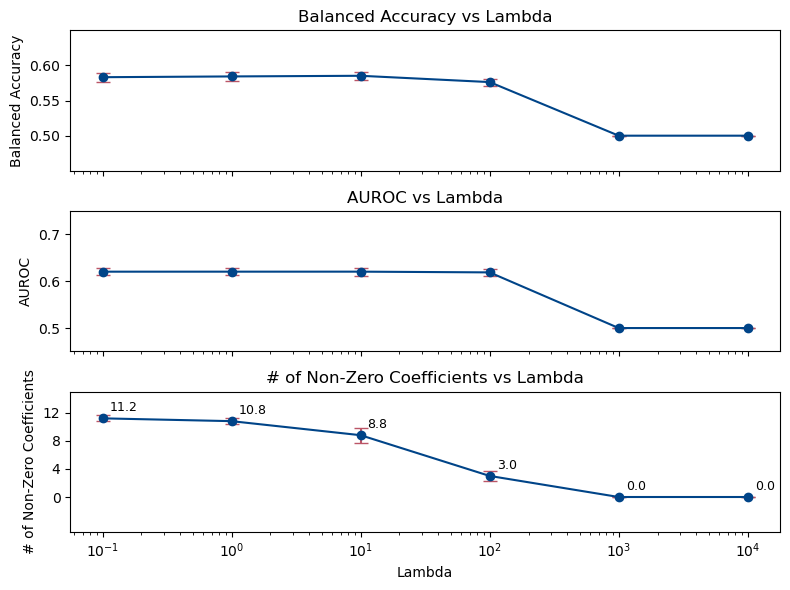

In [8]:
# sort the lambda values
lambda_vals = sorted(results_dict.keys())

# initialize lists to store the aggregated metric means and standard deviations
bal_acc_means, bal_acc_stds = [],[]
auroc_means, auroc_stds     = [],[]
nonzero_means, nonzero_stds = [],[]

# loop over each lambda and compute metrics
for lambda_val in lambda_vals:
    
    cv_results     = results_dict[lambda_val]
    
    # extract balanced accuracy and AUROC scores
    test_bal_acc   = cv_results['test_balanced_accuracy']
    test_roc_auc   = cv_results['test_roc_auc']
    
    # compute mean and standard deviation
    mean_bal_acc   = np.mean(test_bal_acc)
    std_bal_acc    = np.std(test_bal_acc, ddof=1)
    mean_roc_auc   = np.mean(test_roc_auc)
    std_roc_auc    = np.std(test_roc_auc, ddof=1)
    
    # compute number of non-zero coefficients for each fold
    nonzero_counts = [np.count_nonzero(estimator.coef_[0]) for estimator in cv_results['estimator']]
    mean_nonzero   = np.mean(nonzero_counts)
    std_nonzero    = np.std(nonzero_counts, ddof=1)
    
    # Append the computed metrics to the corresponding lists
    bal_acc_means.append(mean_bal_acc)
    bal_acc_stds.append(std_bal_acc)
    auroc_means.append(mean_roc_auc)
    auroc_stds.append(std_roc_auc)
    nonzero_means.append(mean_nonzero)
    nonzero_stds.append(std_nonzero)

# print summary information to screen
header = ("Lambda".ljust(12) + "Balanced Acc (mean ± std)".ljust(27) +
          "AUROC (mean ± std)".ljust(30) + "Non-zero Coeffs (mean ± std)")
print(header)

for i, lambda_val in enumerate(lambda_vals):
    nonzero_str = f"{nonzero_means[i]:10.1f} ± {nonzero_stds[i]:10.1f}"
    print(f"{lambda_val:10.4f}\t" f"{bal_acc_means[i]:0.3f} ± {bal_acc_stds[i]:0.3f}\t\t"
          f"{auroc_means[i]:0.3f} ± {auroc_stds[i]:0.3f}\t\t" f"{nonzero_str}")

# create summary plots
plot_color  = "#004488"
error_color = "#BB5566"
fig, axes   = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# plot Balanced Accuracy
axes[0].errorbar(lambda_vals, bal_acc_means, yerr=bal_acc_stds, fmt='o-', capsize=5, color=plot_color, ecolor=error_color)
axes[0].set_xscale('log')
axes[0].set_ylabel('Balanced Accuracy')
axes[0].set_ylim(0.45, 0.65)
axes[0].set_yticks([0.5, 0.55, 0.6])
axes[0].set_title('Balanced Accuracy vs Lambda')

# plot AUROC
axes[1].errorbar(lambda_vals, auroc_means, yerr=auroc_stds, fmt='o-', capsize=5, color=plot_color, ecolor=error_color)
axes[1].set_xscale('log')
axes[1].set_ylabel('AUROC')
axes[1].set_ylim(0.45, 0.75)
axes[1].set_yticks([0.5, 0.6, 0.7])
axes[1].set_title('AUROC vs Lambda')

# plot number of non-zero coefficients
axes[2].errorbar(lambda_vals, nonzero_means, yerr=nonzero_stds, fmt='o-', capsize=5,color=plot_color, ecolor=error_color)
axes[2].set_xscale('log')
axes[2].set_ylabel('# of Non-Zero Coefficients')
axes[2].set_title('# of Non-Zero Coefficients vs Lambda')
axes[2].set_ylim(-5, 15)
axes[2].set_yticks([0, 4, 8, 12])
axes[2].set_xlabel('Lambda')

# annotate each point with the mean number of non-zero coefficients (to one decimal)
for i, lambda_val in enumerate(lambda_vals):
    axes[2].annotate(f"{nonzero_means[i]:.1f}", (lambda_val, nonzero_means[i]), 
                     textcoords="offset points", xytext=(5, 5), fontsize=9, color='black')

plt.tight_layout()
plt.show()

### Step 4 - Build & test the final model

* It appears that we can achieve close to the best results using *λ* = 100 while giving outselves a small number of features to interpret

In [9]:
# choose our preferred value of lambda
final_lambda        = 100.

# setup the model
final_model         = LogisticRegression(penalty="l1", solver="saga", max_iter=max_iter, C=1/final_lambda)

# fit the model to the data
final_model.fit(X_train, y_train)

# evaluate the final model on the holdout dataset
y_holdout_pred_prob = final_model.predict_proba(X_holdout)[:, 1]
y_holdout_pred      = final_model.predict(X_holdout)
holdout_auroc       = roc_auc_score(y_holdout, y_holdout_pred_prob)
holdout_bal_acc     = balanced_accuracy_score(y_holdout, y_holdout_pred)

print ("Performance on holdout data\n")
print("Holdout AUROC             :", '%.3f' %holdout_auroc)
print("Holdout Balanced Accuracy :", '%.3f' %holdout_bal_acc, "\n")

# extract the nonzero coefficients
coef                = final_model.coef_.flatten()
nonzero_indices     = coef != 0
nonzero_coefs       = coef[nonzero_indices]
nonzero_features    = X_train.columns[nonzero_indices]

# sort coefficients by absolute magnitude in descending order
sorted_indices      = abs(nonzero_coefs).argsort()[::-1]
sorted_features     = nonzero_features[sorted_indices]
sorted_coefs        = nonzero_coefs[sorted_indices]

# print nonzero coefficients
print(len(sorted_coefs), "Nonzero Coefficients (sorted by magnitude)\n")
for feature, value in zip(sorted_features, sorted_coefs):
    print(feature.ljust(26) + ": " + "%.5f" % value)

Performance on holdout data

Holdout AUROC             : 0.618
Holdout Balanced Accuracy : 0.571 

4 Nonzero Coefficients (sorted by magnitude)

Length                    : 0.38294
num_loop_contacting_res   : 0.04540
Travatos_G                : 0.02437
Gc                        : 0.00106


### Step 5 - Assess the results
* Take a minute to think about these results:
    * How is the model performing?
    * How could you begin using this model to generate hypotheses for the importance of certain entanglement features in predicting whether a protein is linked to disease?
* When you are done, discuss your answers with at least one person sitting near you.  